# Paragraph causal relation detection: do they contain a causal relation or not

**Example**: '3-2: <span style="background-color: lightblue;">[concept Giving to the ECB the ultimate responsibility for supervision of banks in the euro area concept]</span> <span style="background-color: pink;">[explanation will decisively contribute to increase explanation]</span> <span style="background-color: lightblue;">[concept confidence between the banks concept]</span> <span style="background-color: pink;">[explanation and in this way increase explanation]</span> <span style="background-color: lightblue;">[concept the financial stability in the euro area concept]</span>. The euro area governments and the European institutions, including naturally the European Commission and the ECB, will do whatever is necessary to secure the financial stability of the euro area.\n'

## 1. Load data

This notebook expects three files in a subdirectory `csv`: `Map_Contents-20200726.csv`, `Speech_Contents-20210520.txt` and `Speeches-20210520.txt`. It will look for files with the speeches in the subdirectory `txt`. The names of the speech files are expected to start with the date followed by a space and the suname of the speaker (currently restricted to one word, see function `get_speech_id`).

If you are just interested in learning what the code is doing, you can skip all code blocks with the commands `import` (load libraries), `assert` (perform tests) and `def` (define functions), and examine the other code blocks.

In [1]:
cd ..

F:\PythonJupyterStudy\CM\CM_Macro\SSIML2021-macro-precision


In [2]:
import os
from src.data.make_dataset import read_data_file
from src.data.make_dataset import make_dataset
import fasttext
from langdetect import detect
from nltk.tokenize import word_tokenize
import numpy as np
import re
import random
import sklearn
from sklearn.metrics import classification_report,confusion_matrix,f1_score
from sklearn.utils import shuffle,resample
from sklearn.model_selection import KFold
import pandas as pd
from termcolor import colored
from IPython.display import clear_output
import matplotlib.pyplot as plt
import itertools

In [3]:
assert os.path.isdir("csv"), 'The directory "csv" does not exist!'
assert os.path.isdir("txt"), 'The directory "txt" does not exist!'
map_contents = read_data_file("csv/Map_Contents-20200726.csv")
speech_contents = read_data_file("csv/Speech_Contents-20210520.txt")
speeches = read_data_file("csv/Speeches-20210520.txt")

In [4]:
#set random seed to keep consistency between different experiments
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)

## 2. Predict presence of causal relations in paragraphs

Steps:

1. store the paragraphs in the data structure X (data) after separating punctuation from words and replacing upper case by lower case
2. create a data structure y (labels) with True for paragraphs with causal relations and False for others
3. predict a label for each paragraph with a machine learning model generated from the other paragraphs
4. evaluate the results

The code in this task uses the packages `fasttext` (for machine learning) and `nltk` (for language processing) 

The task uses limited natural language processing to prepare the data for machine leaning:

1. tokenization: separate punctuation from words
2. conversion of upper case characters to lower case

Other interesting natural language preprocessing steps:

3. part-of-tagging
4. full parsing (Stanford parser)

In [5]:
def make_train_test(X, y, test_index=0):
    train_list = []
    test_list = []
    index = 0
    for key in sorted(X.keys()):
        if index == test_index:
            test_list.append(f"__label__{str(y[key])} {X[key]}")
        else:
            train_list.append(f"__label__{str(y[key])} {X[key]}")
        index += 1
    return train_list, test_list

def make_train_file(file_name, train_list):
    data_file = open(file_name, "w",encoding='utf-8')
    for line in train_list:
        print(line, file=data_file)
    data_file.close()

def decode_label(label):
    return re.sub("__label__", "", label) == "True"

def show_results(results):
    result_list = []
    for key in results:
        result_list.append({"paragraph": key})
        result_list[-1].update(results[key])
    return pd.DataFrame(result_list, index=[""]*len(result_list))

def count_y_values(y):
    values = {}
    for key in y:
        if y[key] not in values:
            values[y[key]] = 0
        values[y[key]] += 1
    table = []
    for key in values:
        table.append({"label": key, "count": values[key], "percentage": f"{round(100*values[key]/len(y), 1)}%"})
    return pd.DataFrame(table, index=[""]*len(table))

def squeal(text):
    clear_output(wait=True)
    print(text)

def make_fasttext_data(data_in):
    data_out = []
    for paragraph, label in data_in:
        data_out.append("__label__" + str(label) + " " + paragraph)
    return data_out

def run_experiments(X, y, wordNgrams=1, pretrainedVectors=""):
    y_pred = []
    y_true = [ y[key] for key in X if key in y]
    counter = 0
    data = np.array([ (X[key], y[key]) for key in X if key in y])
    for train_items, test_items in sklearn.model_selection.KFold(n_splits=10).split(X):
        train_data = make_fasttext_data(data[train_items])
        make_train_file("train_file.txt", train_data)
        model = fasttext.train_supervised("train_file.txt", dim=300, pretrainedVectors=pretrainedVectors, wordNgrams=wordNgrams)
        test_data = make_fasttext_data(data[test_items])
        predicted_labels = model.predict(test_data)
        y_pred.extend(predicted_labels[0])
        counter += 1
        squeal(f"Ran experiment {counter} of 10")
        
    y_pred = [decode_label(label[0]) for label in y_pred]
    return y_true, y_pred

def evaluate_results(y_true, y_pred):
    precision, recall, fscore, _ = sklearn.metrics.precision_recall_fscore_support(y_true, y_pred, average='macro')
    print(f"Precision: {precision:0.3f}; recall: {recall:0.3f}; F1: {fscore:0.3f}")

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return

The variable `X` in the next code block contains all the data (paragraphs) available for machine learning. The variable `y` contains all the associated labels, with values `True` or `False`.   

In [6]:
X, y = make_dataset(speeches, speech_contents, map_contents)

skipping file in language fr: 2009-12-01 Sarkozy Elysee (Economy) ann fr.txt
skipping file in language fr: 2009-12-14 Sarkozy Elysee (Economy) ann fr.txt
skipping file in language fr: 2010-04-20 Barroso European Commission ann fr.txt
skipping file in language fr: 2011-01-13 Sarkozy gb ann.txt
skipping file in language nl: 2011-04-06 Rutte FD evenement ann NL.txt
skipping file in language nl: 2011-09-27 Rutte Rijksoverheid ann.txt
skipping file in language nl: 2011-10-28 Knot dnb_01 ANN NL.txt
skipping file in language de: 2012-01-06 Rutte CSU klausurtagung ann G.txt
skipping file in language unk: 2012-07-26 Barroso European Commission.txt
skipping file in language fr: 2012-08-30 Hollande SFM2020 ann fr.txt
skipping file in language fr: 2013-02-19 Hollande SFM2020 ann fr.txt
skipping file in language fr: 2013-04-17 Hollande SFM2020 ann fr.txt
skipping file in language de: 2013-11-21 Merkel Bundesregerung ann g.txt
skipping file in language de: 2014-02-27 Merkel Bundesregerung ann g.txt


### 2. Balance data

In [7]:
count_y_values(y)

,label,count,percentage
,True,660,73.6%
,False,237,26.4%


1.First of all, there still are some *Missing value* paragraphs in our data, therefore we need to remove them. <br><br>
2.In addition, our data is highly imbalanced, that's means we have twice as many paragraphs with causal relations compared to paragraphs without causal relations. This issue would make our classifier guess a paragraph contains causal relation with a high probability because it would be less likely to make a mistake, but this is not what we want. Therefore we need to balance our data.<br>

<h1><center>Undersampling VS  Oversampling</center></h1>

![](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/resampling.png)

There are two common methods of balancing data: Undersampling and Oversampling, the former refers to the random sampling from the class which contains more data in order to make the dataset balanced. The latter is to copy data points from the class with less data, then make the dataset balanced.<br><br>
Both methods have their advantages and disadvantages, where Undersampling will make us discard some existing data, which will cost our model some training opportunities given our small data size. Nonetheless, oversampling "manually" improves the accuracy of the model because some data appear twice in the dataset, which means that the data points that appear in the test set are likely to appear in the training set as well.

In [8]:
def over_sampling(X,y):
    """
    remove Missing value first, then output two balanced dataset (Undersampling and Oversampling)
    Input: X,y before pre-processing
    Output: dataframes after removing missing value, Undersampling and Oversampling
    """
    df = pd.DataFrame({'X':pd.Series(X),'y':pd.Series(y)})
    df_true = df[df['y'] == True]
    df_false = df[df['y'] == False] 
    
    #Upsampling, for the class with less data, copy some data 
    df_false_upsampled = resample(df_false,random_state=42,n_samples=len(df_true),replace=True)
    df_upsampled = pd.concat([df_false_upsampled,df_true])
    df_upsampled = shuffle(df_upsampled)
    
    print('\nWe totally have {} training data after oversampling.'.format(len(df_upsampled)))
    return df_upsampled

def transform_df(df_upsampled):
    #transform label to int
    df_upsampled.loc[df_upsampled['y'] == 'True', 'y'] = 1
    df_upsampled.loc[df_upsampled['y'] == 'False', 'y'] = 0
    df_upsampled.y = df_upsampled.y.astype(int)
    
    return df_upsampled

### Model processing flow

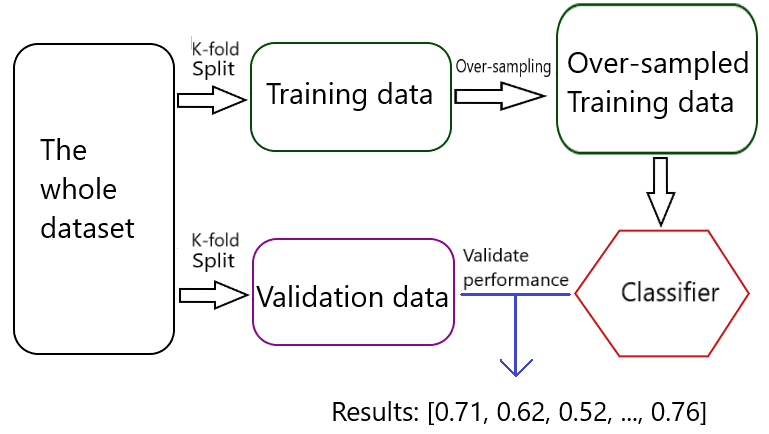


As shown in the Model processing flow above, we will only use over-sampling in a appropriate way: After using kfold spliting training set and validation set, only the training set data will be over-sampled, which ensure that we won't have duplicate validation data.

### 3. N-gram models

### <center>Understand confusion matrix<center>


![](https://miro.medium.com/max/693/1*7EYylA6XlXSGBCF77j_rOA.png)
    
<center>$Recall: \Large\frac{TP}{TP+FN}$ $\quad\quad\quad\quad Precision: \Large\frac{TP}{TP+FP}$<center><br>
<center>$F1: \Large\frac{2*Recall*Precision}{Recall+Precision}$<center>

In [20]:
def run(X, y, wordNgrams=1, pretrainedVectors=""):
    print('Preprocessing:\n')
    df = pd.DataFrame({'X':pd.Series(X),'y':pd.Series(y)})
    print('{} na data found'.format(len(df[df['X'].isna() == True].index)))
    df = df.dropna()
    print('na data dropped')
    
    
    kf = KFold(n_splits=10)
    kf.get_n_splits(df)
    k = 0
    
    training_pred = []
    training_true = []
    evaluation_pred = []
    evaluation_true = []
    
    for train_index, test_index in kf.split(df):
        print('--------------------------------------------------------Now is {} fold--------------------------------------------------------'.format(k))
        X_train, X_test = df['X'][train_index], df['X'][test_index]
        y_train, y_test = df['y'][train_index], df['y'][test_index]
        
        print('[X training set shape, X training set shape]:',X_train.shape,X_test.shape)
        

        # over-sample the Training set, then transform them to right form
        df_train_upsampled = over_sampling(X_train, y_train)
        # transform testset to right form
        df_test = pd.DataFrame({'X':pd.Series(X_test),'y':pd.Series(y_test)})

        train_upsampled = []
        for index, row in df_train_upsampled.iterrows():
            train_upsampled.append([row['X'], row['y']])
        
        test_set = []
        for index, row in df_test.iterrows():
            test_set.append([row['X'], row['y']])
        
        train_data = make_fasttext_data(train_upsampled)
        make_train_file("train_file.txt", train_data)
        model = fasttext.train_supervised("train_file.txt", dim=300, pretrainedVectors=pretrainedVectors, wordNgrams=wordNgrams)
        test_data = make_fasttext_data(test_set)
        
        eval_pred = model.predict(test_data)
        train_pred = model.predict(train_data)
        train_pred = [decode_label(label[0]) for label in train_pred[0]]
        eval_pred = [decode_label(label[0]) for label in eval_pred[0]]
        
        
        train_label = df_train_upsampled['y']
        eval_label = df_test['y']
        
        training_pred.append(train_pred)
        training_true.append(train_label)
        evaluation_pred.append(eval_pred)
        evaluation_true.append(eval_label)
        
        k+=1
        
    def flatten(t):
        return [item for sublist in t for item in sublist]
    
    evaluation_true = flatten(evaluation_true)
    evaluation_pred = flatten(evaluation_pred)
    training_true = flatten(training_true)
    training_pred = flatten(training_pred)
    
    
    target_names = ['class 0', 'class 1']
    
    #For training data
    print('classification report on training set is:\n')
    clas_reprt_train = classification_report(training_true, training_pred, target_names=target_names)
    print(clas_reprt_train)
    
    print('confusion matrix on training set is:\n')
    cm_train = confusion_matrix(training_true, training_pred)
    plot_confusion_matrix(cm_train, ['No causal relation', 'Has causal relation'], normalize=False)
    
    #For evaluation data
    print('classification report on validation set is:\n')
    clas_reprt_eval = classification_report(evaluation_true, evaluation_pred, target_names=target_names)
    print(clas_reprt_eval)
    
    print('confusion matrix on validation set is:\n')
    cm_eval = confusion_matrix(evaluation_true, evaluation_pred)
    plot_confusion_matrix(cm_eval, ['No causal relation', 'Has causal relation'], normalize=False)   
    
    return 

Preprocessing:

19 na data found
na data dropped
--------------------------------------------------------Now is 0 fold--------------------------------------------------------
[X training set shape, X training set shape]: (790,) (88,)

We totally have 1162 training data after oversampling.
--------------------------------------------------------Now is 1 fold--------------------------------------------------------
[X training set shape, X training set shape]: (790,) (88,)

We totally have 1148 training data after oversampling.
--------------------------------------------------------Now is 2 fold--------------------------------------------------------
[X training set shape, X training set shape]: (790,) (88,)

We totally have 1150 training data after oversampling.
--------------------------------------------------------Now is 3 fold--------------------------------------------------------
[X training set shape, X training set shape]: (790,) (88,)

We totally have 1166 training data after o

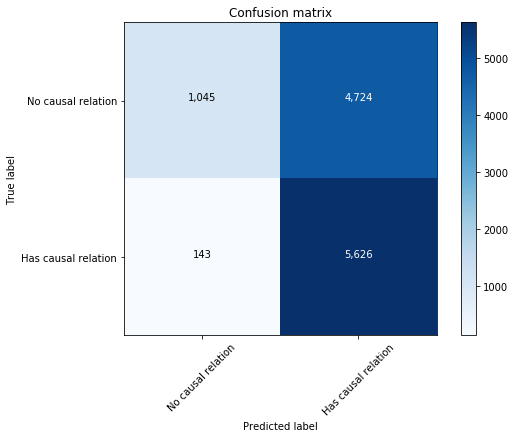

classification report on validation set is:

              precision    recall  f1-score   support

     class 0       0.55      0.11      0.18       237
     class 1       0.75      0.97      0.84       641

    accuracy                           0.74       878
   macro avg       0.65      0.54      0.51       878
weighted avg       0.69      0.74      0.66       878

confusion matrix on validation set is:



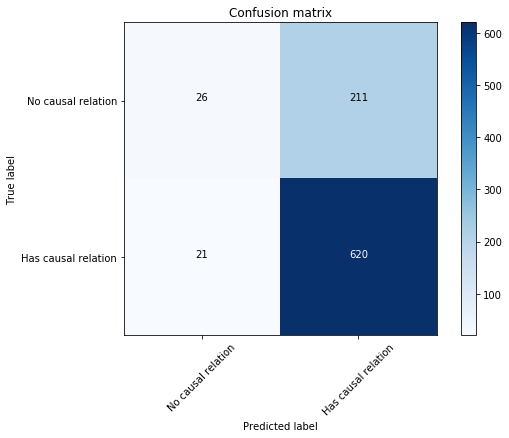

In [21]:
run(X, y, wordNgrams=1)

Preprocessing:

19 na data found
na data dropped
--------------------------------------------------------Now is 0 fold--------------------------------------------------------
[X training set shape, X training set shape]: (790,) (88,)

We totally have 1162 training data after oversampling.
--------------------------------------------------------Now is 1 fold--------------------------------------------------------
[X training set shape, X training set shape]: (790,) (88,)

We totally have 1148 training data after oversampling.
--------------------------------------------------------Now is 2 fold--------------------------------------------------------
[X training set shape, X training set shape]: (790,) (88,)

We totally have 1150 training data after oversampling.
--------------------------------------------------------Now is 3 fold--------------------------------------------------------
[X training set shape, X training set shape]: (790,) (88,)

We totally have 1166 training data after o

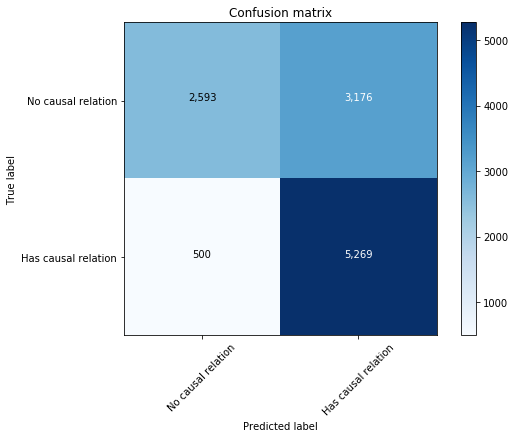

classification report on validation set is:

              precision    recall  f1-score   support

     class 0       0.42      0.24      0.31       237
     class 1       0.76      0.88      0.81       641

    accuracy                           0.71       878
   macro avg       0.59      0.56      0.56       878
weighted avg       0.67      0.71      0.68       878

confusion matrix on validation set is:



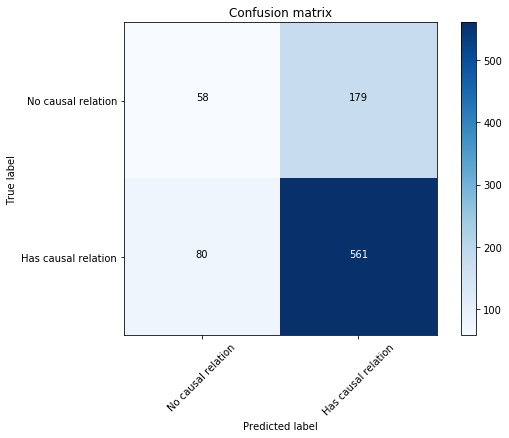

In [14]:
run(X, y, wordNgrams=2)

Preprocessing:

19 na data found
na data dropped
--------------------------------------------------------Now is 0 fold--------------------------------------------------------
[X training set shape, X training set shape]: (790,) (88,)

We totally have 1162 training data after oversampling.
--------------------------------------------------------Now is 1 fold--------------------------------------------------------
[X training set shape, X training set shape]: (790,) (88,)

We totally have 1148 training data after oversampling.
--------------------------------------------------------Now is 2 fold--------------------------------------------------------
[X training set shape, X training set shape]: (790,) (88,)

We totally have 1150 training data after oversampling.
--------------------------------------------------------Now is 3 fold--------------------------------------------------------
[X training set shape, X training set shape]: (790,) (88,)

We totally have 1166 training data after o

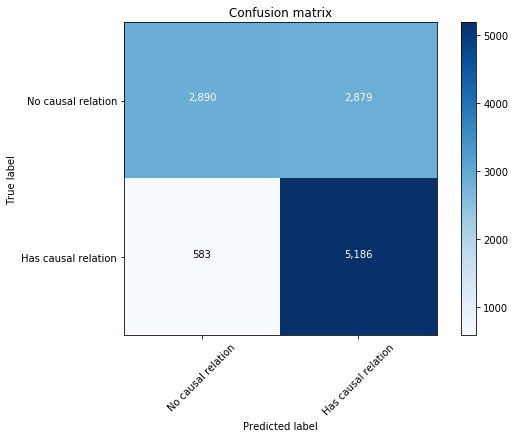

classification report on validation set is:

              precision    recall  f1-score   support

     class 0       0.39      0.28      0.32       237
     class 1       0.76      0.84      0.80       641

    accuracy                           0.69       878
   macro avg       0.57      0.56      0.56       878
weighted avg       0.66      0.69      0.67       878

confusion matrix on validation set is:



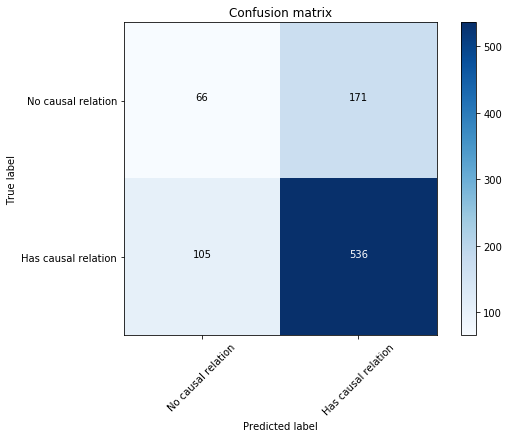

In [15]:
run(X, y, wordNgrams=3)

#### To sum up:<br>
* As can be seen, after using balanced data, it is also difficult to determine whether a paragraph has a causal relationship in our n-gram model.<br>
* classifiers basically unable to distinguish a passage without causality.<br>


Model| training set macro precision | training set macro recall | training set macro F1| evaluation set macro precision | evaluation set macro recall | evaluation set macro F1|
----------| --------- | ------ | ---- | ---------|----------| --------- | 
Uni-gram           | 0.71        | 0.58     | <b>0.50</b> | 0.65 | 0.54 | <b>0.51</b> |
Bi-gram            | 0.73        | 0.68    | <b>0.66</b> | 0.59 | 0.56 | <b>0.56</b> |
Tri-gram           | 0.74        | 0.70    | <b>0.69</b> | 0.57 | 0.56 | <b>0.56</b> |
Transfer learning (Bert + LR)   | 0.90         | 0.90    | <b>0.90</b> | 0.59 | 0.60 | <b>0.59</b> |
Bert           | 0.91        | 0.91     | <b>0.91</b> | 0.63 | 0.61 | <b>0.62</b> |




### 4. N-gram models with pre-trained word embedding

* Fast-text pretrained word embedding (The training time will be extremely long)<br>
* <h4>Using un-balanced data

Preprocessing:

19 na data found
na data dropped
--------------------------------------------------------Now is 0 fold--------------------------------------------------------
[X training set shape, X training set shape]: (790,) (88,)

We totally have 1162 training data after oversampling.
--------------------------------------------------------Now is 1 fold--------------------------------------------------------
[X training set shape, X training set shape]: (790,) (88,)

We totally have 1148 training data after oversampling.
--------------------------------------------------------Now is 2 fold--------------------------------------------------------
[X training set shape, X training set shape]: (790,) (88,)

We totally have 1150 training data after oversampling.
--------------------------------------------------------Now is 3 fold--------------------------------------------------------
[X training set shape, X training set shape]: (790,) (88,)

We totally have 1166 training data after o

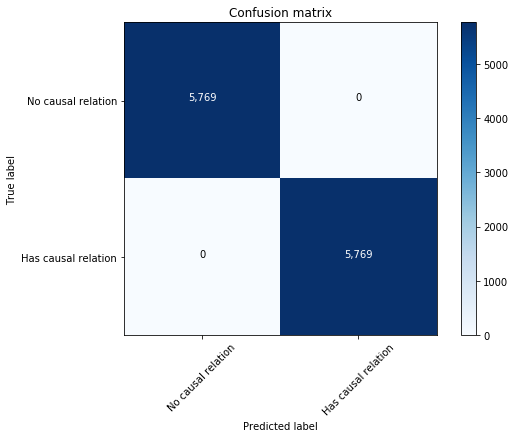

classification report on validation set is:

              precision    recall  f1-score   support

     class 0       0.52      0.39      0.45       237
     class 1       0.79      0.87      0.83       641

    accuracy                           0.74       878
   macro avg       0.66      0.63      0.64       878
weighted avg       0.72      0.74      0.73       878

confusion matrix on validation set is:



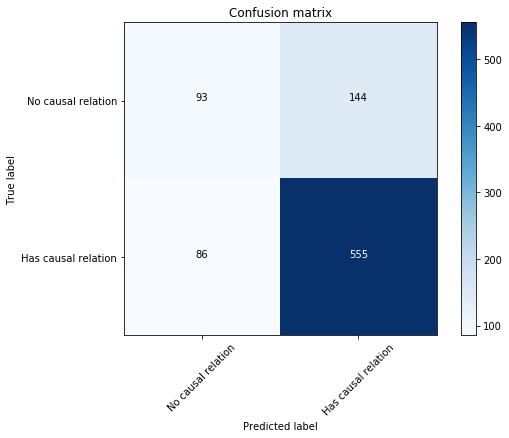

In [22]:
run(X, y, wordNgrams=1, pretrainedVectors='wiki.en.vec')

#### unfinished below

In [ ]:
run(X, y, wordNgrams=2, pretrainedVectors='wiki.en.vec')

Preprocessing:

19 na data found
na data dropped
--------------------------------------------------------Now is 0 fold--------------------------------------------------------
[X training set shape, X training set shape]: (790,) (88,)

We totally have 1162 training data after oversampling.
--------------------------------------------------------Now is 1 fold--------------------------------------------------------
[X training set shape, X training set shape]: (790,) (88,)

We totally have 1148 training data after oversampling.
--------------------------------------------------------Now is 2 fold--------------------------------------------------------
[X training set shape, X training set shape]: (790,) (88,)

We totally have 1150 training data after oversampling.
--------------------------------------------------------Now is 3 fold--------------------------------------------------------
[X training set shape, X training set shape]: (790,) (88,)

We totally have 1166 training data after o

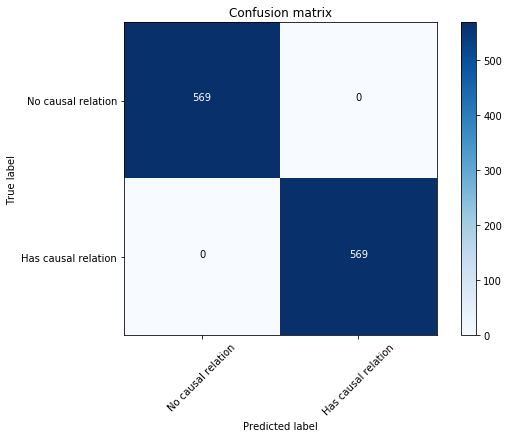

None
classification report of best model on validation set is:

              precision    recall  f1-score   support

     class 0       0.54      0.44      0.48        16
     class 1       0.88      0.92      0.90        72

    accuracy                           0.83        88
   macro avg       0.71      0.68      0.69        88
weighted avg       0.82      0.83      0.82        88

confusion matrix of best model is on validation set:



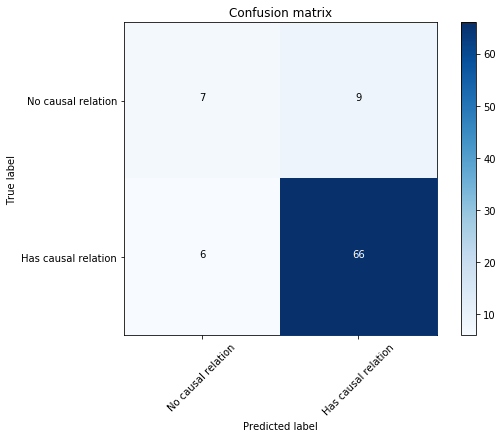

None


In [14]:
run(X, y, wordNgrams=3, pretrainedVectors='wiki.en.vec')

#### To sum up:<br>
###### unfinished

Model| training set macro precision | training set macro recall | training set macro F1| evaluation set macro precision | evaluation set macro recall | evaluation set macro F1|
----------| --------- | ------ | ---- | ---------|----------| --------- | 
Uni-gram           | 0.71        | 0.58     | <b>0.50</b> | 0.65 | 0.54 | <b>0.51</b> |
Bi-gram            | 0.73        | 0.68    | <b>0.66</b> | 0.59 | 0.56 | <b>0.56</b> |
Tri-gram           | 0.74        | 0.70    | <b>0.69</b> | 0.57 | 0.56 | <b>0.56</b> |
Transfer learning (Bert + LR)   | 0.90         | 0.90    | <b>0.90</b> | 0.59 | 0.60 | <b>0.59</b> |
Bert           | 0.91        | 0.91     | <b>0.91</b> | 0.63 | 0.61 | <b>0.62</b> |